In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
from statsmodels.formula.api import ols

import geopandas as gpd

import dython

from sklearn.feature_selection import SelectFpr, chi2, SelectKBest, SelectFwe, f_classif, SelectFdr

In [2]:
relative_dir = "../data/curated/"
income = pd.read_csv("../data/raw/external/vic_income.csv", index_col=0)
mapping = pd.read_csv(relative_dir + "sa2_postcode_mapping_2021.csv")
properties = pd.read_csv(relative_dir + "categorised_distances.csv", index_col=0)
census = pd.read_csv(relative_dir + "census_data.csv")

In [3]:
properties['Postcode'] = properties['Postcode'].astype(str)

### Add Mapping

In [4]:
mapping['postcode_2021'] = mapping['postcode_2021'].astype(str)

In [5]:
properties = pd.merge(properties, mapping, left_on='Postcode', right_on='postcode_2021').drop('postcode_2021', axis=1)

### Add Census Data

In [6]:
census = census[['sa2_2021', 'Tot_persons_C21_P', 'Med_mortg_rep_mon_C2021', 'Med_person_inc_we_C2021', 'Med_rent_weekly_C2021', 'Med_tot_hh_inc_wee_C2021', 'Average_hh_size_C2021']]
census['sa2_2021'] = census['sa2_2021'].astype(str)

In [7]:
properties['sa2_2021'] = properties['sa2_2021'].astype(str)
properties = properties.rename({'sa2_2021':'SA2'})

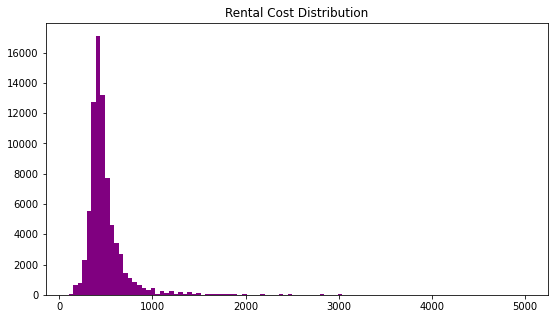

In [8]:
# Rental Cost Distribution
plt.figure(figsize = (9, 5))
plt.title('Rental Cost Distribution')
plt.hist(properties['Cost'], bins=100, color='purple')
plt.savefig('../plots/cost_distribution.jpg')
plt.show()

## Continuous Data Correlations
*Note:* We treat the ordinal features as continuous in order to keep ordering information.

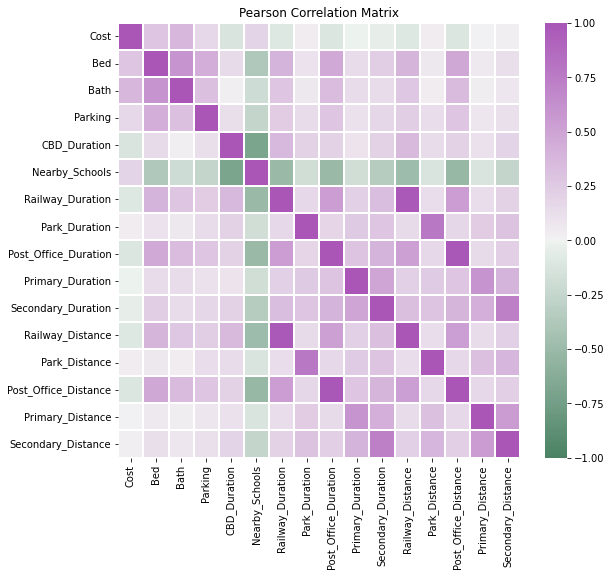

In [9]:
corrmat = properties.corr(method='pearson')
f, ax = plt.subplots(figsize =(9, 8))
colours = sns.diverging_palette(145, 300, s=60, as_cmap=True)
# possible colours: "coolwarm", "vlag"
sns.heatmap(corrmat, ax = ax, cmap=colours, linewidths = 0.1, center=0, vmin=-1)
plt.title('Pearson Correlation Matrix')
plt.savefig('../plots/correlation.jpg')
plt.show()

Find the most correlated features with rental cost of property.

In [10]:
sorted_mat = corrmat.unstack().sort_values()

# reformat series into data frame
df = pd.DataFrame(data=sorted_mat)
df.rename({0:'correlation'}, axis=1, inplace=True)
df['Index'] = df.index
df = pd.concat(
        [df.drop('Index', axis=1), 
        df['Index'].apply(pd.Series)]
    , axis=1)

# output correlation list
cost_correlations = pd.DataFrame(df[df[0] == 'Cost']['correlation'])
cost_correlations['abs_corr'] = abs(cost_correlations['correlation'])
cost_correlations.sort_values(by='abs_corr', ascending=False)

correlation  abs_corr
Cost Cost                     1.000000  1.000000
     Bath                     0.374861  0.374861
     Bed                      0.274215  0.274215
     Nearby_Schools           0.189703  0.189703
     Parking                  0.158559  0.158559
     CBD_Duration            -0.125417  0.125417
     Post_Office_Duration    -0.116706  0.116706
     Post_Office_Distance    -0.111993  0.111993
     Railway_Duration        -0.100313  0.100313
     Railway_Distance        -0.093912  0.093912
     Secondary_Duration      -0.046270  0.046270
     Park_Distance            0.036882  0.036882
     Park_Duration            0.032502  0.032502
     Secondary_Distance       0.020307  0.020307
     Primary_Distance         0.009759  0.009759
     Primary_Duration        -0.008939  0.008939

## Continuous and Categorical Data Correlations

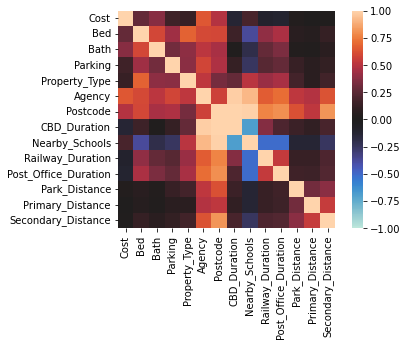

In [11]:
# get correlation of numeric attributes with cost
exclusions = ['Name', 'Coordinates', 'sa2_2021', 'Post_Office_Distance', 'Railway_Distance', 'Park_Duration', 'Secondary_Duration', 'Primary_Duration']
corr_data = properties.drop(exclusions, axis=1)
corr_mat = dython.nominal.associations(corr_data, annot=False)

In [12]:
sorted_mat = corr_mat['corr'].unstack().sort_values()

# reformat series into data frame
df = pd.DataFrame(data=sorted_mat)
df.rename({0:'correlation'}, axis=1, inplace=True)
df['Index'] = df.index
df = pd.concat(
        [df.drop('Index', axis=1), 
        df['Index'].apply(pd.Series)]
    , axis=1)

# output correlation list
cost_correlations = pd.DataFrame(df[df[0] == 'Cost']['correlation'])
cost_correlations['abs_corr'] = abs(cost_correlations['correlation'])
cost_correlations = cost_correlations.sort_values(by='abs_corr', ascending=False)

# remove multi-level indexing
cost_correlations.index = cost_correlations.index.droplevel(0)

cost_correlations.drop('Cost')

,correlation,abs_corr
Agency,0.647472,0.647472
Postcode,0.489504,0.489504
Bath,0.374861,0.374861
Bed,0.274215,0.274215
Nearby_Schools,0.189703,0.189703
Parking,0.158559,0.158559
Property_Type,0.131507,0.131507
CBD_Duration,-0.125417,0.125417
Post_Office_Duration,-0.116706,0.116706
Railway_Duration,-0.100313,0.100313


#### Highly correlated features
- Postcode and SA2 are extremely correlated, so only include postcode which has slightly higher correlation with cost. 
- all distance/duration combos - pick best from each category
    - keep duration: CBD, station
    - keep distance: park, secondary and primary schools (kids can't drive and people likely want to walk to parks, not drive)
- Postcode highly correlated with everything
- cbd_duration: postcode and agency
- Median and total income - only include median
- median rent and mortgage payments - makes sense for landlords
- total household income and personal income - only keep household income

#### Interesting notes
- Highest correlations are for features already on property website - good, makes sense, they're doing the right thing.
- people do not care about schools, if anything they don't want to live near schools. Only a minority of people have children and care about that? People with and without kids cancel eachother out? Families less likely to rent than buy. 

## Categorical ANOVAs

In [13]:
# test for relationship with categorical variables using one-way ANOVA
categoricals = ['Postcode', 'Property_Type', 'Agency']

for c in categoricals:
    model = ols('Cost ~ '+c, data = properties).fit() # Oridnary least squares
    result_anova = sm.stats.anova_lm(model) # ANOVA Test
    print(result_anova)

               df        sum_sq       mean_sq          F  PR(>F)
Postcode    408.0  1.089675e+09  2.670772e+06  59.972065     0.0
Residual  77648.0  3.457946e+09  4.453361e+04        NaN     NaN
                    df        sum_sq       mean_sq           F         PR(>F)
Property_Type      9.0  7.864734e+07  8.738594e+06  152.612462  1.508703e-287
Residual       78047.0  4.468973e+09  5.726003e+04         NaN            NaN
               df        sum_sq       mean_sq          F  PR(>F)
Agency     1384.0  1.906454e+09  1.377496e+06  39.988151     0.0
Residual  76672.0  2.641166e+09  3.444760e+04        NaN     NaN


All p values are less than 0.05 so all attributes are significant.

## Feature Selection

In [15]:
y = properties['Cost']
X = properties.drop(['Cost', 'Name', 'Coordinates', 'Property_Type', 'Agency'], axis=1)

# selector = SelectKBest(score_func=chi2, k=10)
selector = SelectFwe(score_func=chi2, alpha=0.05)
new_data = selector.fit_transform(X, y)

mask = selector.get_support()
new_features = X.columns[mask]
new_features

ValueError: Unknown label type: (array([440., 440., 440., ..., 550., 550., 550.]),)